# Imports

In [88]:
import random
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    confusion_matrix,
    mean_absolute_error,
    mean_absolute_percentage_error,
    PredictionErrorDisplay,
    r2_score,
)

# Dataset Overview

In [23]:
# Load dataset
with open("../data/timeInterval_10-rand_sample.pkl", "rb") as f:
    dataset = pickle.load(f)
# print(dataset.head())
print(list(dataset.columns))
print(dataset["period_end_time"])

['amount_old_data', 'amount_new_data', 'total_data', 'ratio_new_old_data', 'curr_fraud_rate', 'old_fraud_rate', 'retrain_delta', 'period_start_time', 'period_end_time', 'curr_retrain_hour', 'prev_retrain_hour', 'retrain_times', 'recompute_threshold_times', 'retrain_timestamp', 'thresholds', 'curr_tn', 'curr_fp', 'curr_fn', 'curr_tp', 'prev_tn', 'prev_fp', 'prev_fn', 'prev_tp', 'next2prev_tn', 'next2prev_fp', 'next2prev_fn', 'next2prev_tp', 'scores-JSD', 'uncertainty-JSD', 'uncertainty_fraud-JSD', 'uncertainty_legit-JSD', 'avg-TP-retrain', 'avg-TN-retrain', 'avg-FP-retrain', 'avg-FN-retrain', 'avg-TPR-retrain', 'avg-TNR-retrain', 'avg-FNR-retrain', 'avg-FPR-retrain', 'stdv-TP-retrain', 'stdv-TN-retrain', 'stdv-FP-retrain', 'stdv-FN-retrain', '50-TP-retrain', '50-TN-retrain', '50-FP-retrain', '50-FN-retrain', '75-TP-retrain', '75-TN-retrain', '75-FP-retrain', '75-FN-retrain', '90-TP-retrain', '90-TN-retrain', '90-FP-retrain', '90-FN-retrain', '99-TP-retrain', '99-TN-retrain', '99-FP-retr

# Split dataset

In [70]:
# Split function
def __prepare_splits(
    dataset,
    time_interval,
    sat_value,
    train_split_percent: float = 0.7,  # 70% for train and val; 30% for test
    val_split_percent: float = 0.2,  # 80% for train; 20% for val
):
    # transform confusion matrix features into rates
    for prefix in ["curr", "prev", "next2prev"]:
        dataset[f"{prefix}-TPR"] = dataset[f"{prefix}_tp"] / (
            dataset[f"{prefix}_tp"] + dataset[f"{prefix}_fn"]
        )
        dataset[f"{prefix}-TNR"] = dataset[f"{prefix}_tn"] / (
            dataset[f"{prefix}_tn"] + dataset[f"{prefix}_fp"]
        )
        dataset[f"{prefix}-FNR"] = dataset[f"{prefix}_fn"] / (
            dataset[f"{prefix}_tp"] + dataset[f"{prefix}_fn"]
        )
        dataset[f"{prefix}-FPR"] = dataset[f"{prefix}_fp"] / (
            dataset[f"{prefix}_tn"] + dataset[f"{prefix}_fp"]
        )

    # add delta column
    dataset["delta-TPR"] = dataset["avg-TPR-retrain"] - dataset["curr-TPR"]
    dataset["delta-TNR"] = dataset["avg-TNR-retrain"] - dataset["curr-TNR"]
    dataset["delta-TPR-nop"] = dataset["avg-TPR-no_retrain"] - dataset["curr-TPR"]
    dataset["delta-TNR-nop"] = dataset["avg-TNR-no_retrain"] - dataset["curr-TNR"]

    # split dataset into train, val, test
    duration = dataset["period_end_time"].max() - dataset["period_end_time"].min()

    # use train_split_percent % for training
    train_test_split_time = int(duration.days * train_split_percent) * 24  # in hours
    # ensure it is a multiple of the time_interval
    if train_test_split_time % time_interval != 0:
        train_test_split_time = train_test_split_time - (
            train_test_split_time % time_interval
        )
    test_start_time = dataset["prev_retrain_hour"].min() + train_test_split_time

    # split data set into train + val and test
    train_val_split = dataset.loc[dataset["curr_retrain_hour"] < test_start_time]
    test_split = dataset.loc[dataset["prev_retrain_hour"] >= test_start_time].copy()

    # split train into train (1-val_split_percent) and val (val_split_percent)
    val_split_time = train_val_split["curr_retrain_hour"].min() + int(
        train_test_split_time * (1 - val_split_percent)
    )

    train_split = train_val_split.loc[
        train_val_split["curr_retrain_hour"] < val_split_time
    ]
    val_split = train_val_split.loc[
        (train_val_split["prev_retrain_hour"] >= val_split_time)
        # & (train_val_split["curr_retrain_hour"] >= val_split_time)
    ].copy()

    # saturate features in val and test
    max_val = train_split["total_data"].max()
    print(max_val)
    val_split["total_data"] = val_split["total_data"].apply(
        lambda x: x if x < sat_value * max_val else sat_value * max_val
    )
    max_val = train_split["amount_old_data"].max()
    print(max_val)

    val_split["amount_old_data"] = val_split["amount_old_data"].apply(
        lambda x: x if x < sat_value * max_val else sat_value * max_val
    )
    max_val = train_split["ratio_new_old_data"].max()
    print(max_val)
    val_split["ratio_new_old_data"] = val_split["ratio_new_old_data"].apply(
        lambda x: x if x < sat_value * max_val else sat_value * max_val
    )
    print("prepare splits completed")
    return [train_split, val_split, test_split], test_start_time


train_split_percent = 0.7  # 70% for train and val; 30% for test
val_split_percent = 0.2  # 80% for train; 20% for val

splits, test_start_time = __prepare_splits(
    dataset, 10, 0.9, train_split_percent, val_split_percent
)

365166
363247
1.651240797479199
prepare splits completed


# AIPs

[D] Training TPR and TNR delta models
========= Evaluating TPR RB model validation performance ===========
[D] MAE = 0.11469290923503073
[D] MAPE = 2.047496628577502
[D] CORR_COEF = PearsonRResult(statistic=0.6948443708130515, pvalue=4.0326080527631064e-125)
[D] R^2 score = 0.43385339986438265
-------------------------------------------------------------
========= Evaluating TPR RB model test performance ===========
[D] MAE = 0.1329472707220381
[D] MAPE = 2036499195237.8855
[D] CORR_COEF = PearsonRResult(statistic=0.708235622835465, pvalue=0.0)
[D] R^2 score = 0.2323402576852015
-------------------------------------------------------------
========= Evaluating TNR RB model validation performance ===========
[D] MAE = 0.00745370770765669
[D] MAPE = 3.189355222700122
[D] CORR_COEF = PearsonRResult(statistic=0.41805339535880504, pvalue=9.561107961810354e-38)
[D] R^2 score = -0.21736879680190424
-------------------------------------------------------------
========= Evaluating TNR RB model

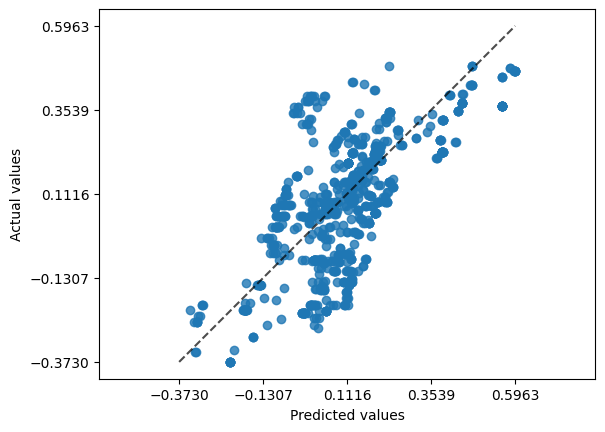

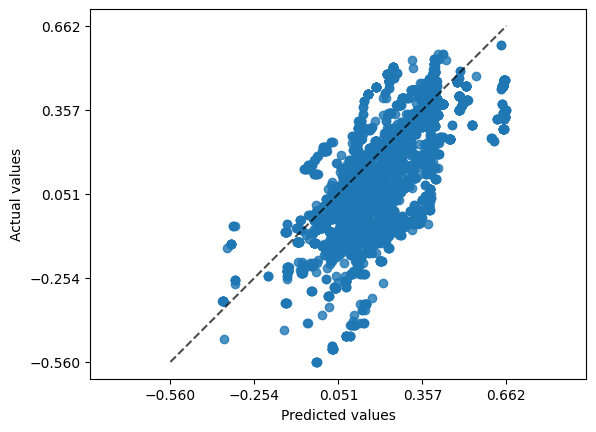

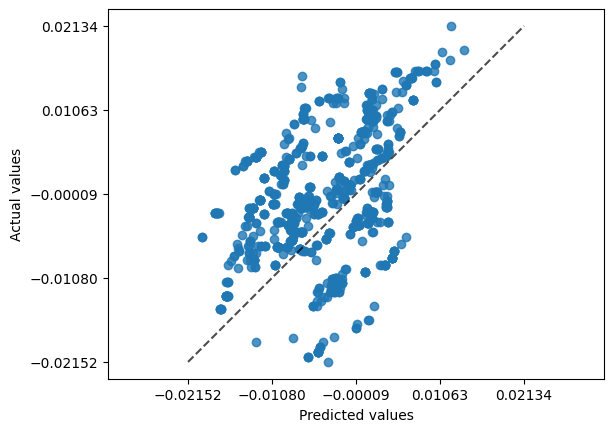

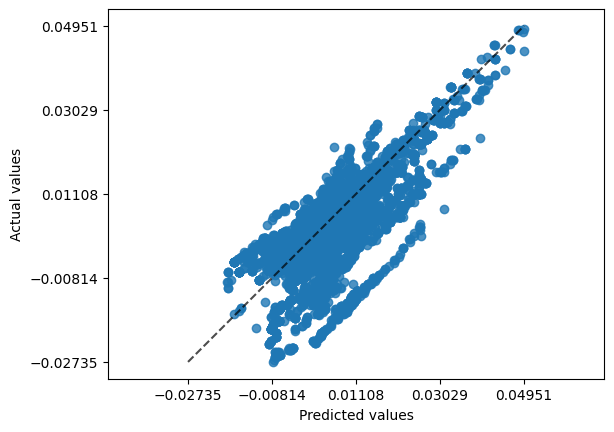

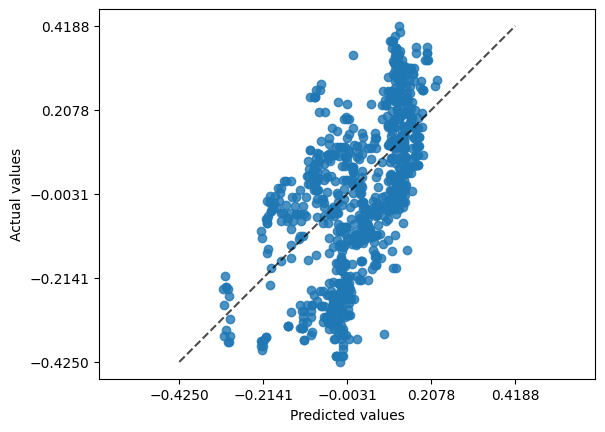

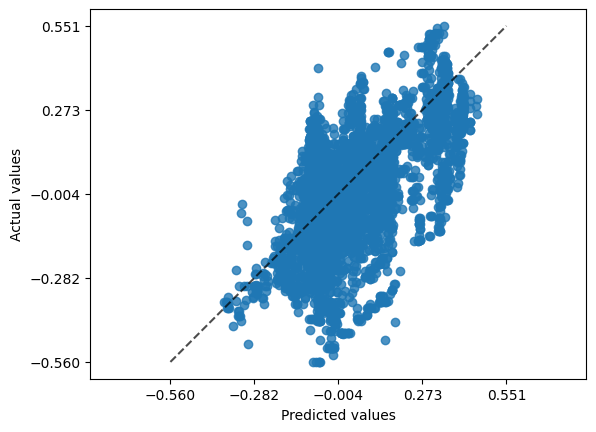

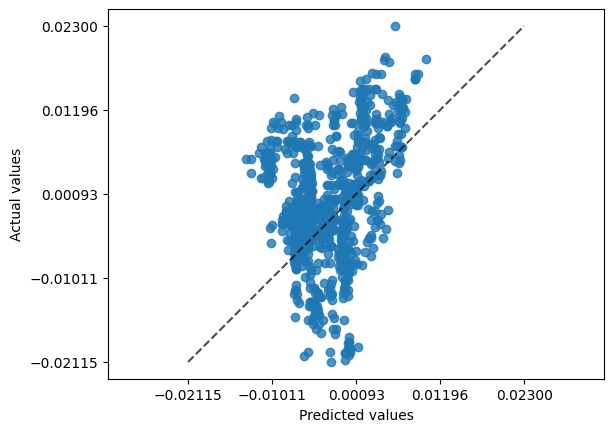

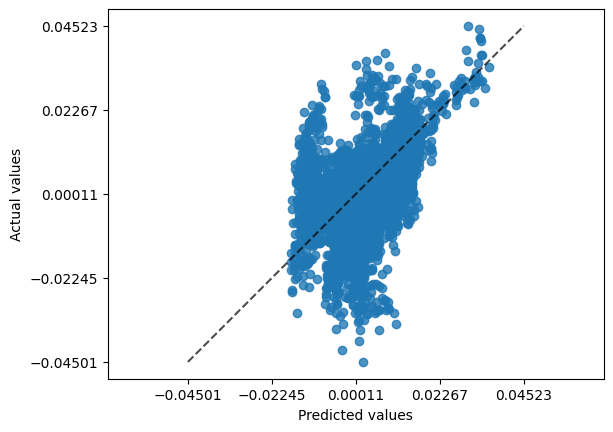

In [90]:
def __init_benefits_models(
    model_type, nop_models, seed, retrain_models, train_split, val_split, test_split
):

    # specify model features
    benefits_model_features = [
        "amount_new_data",
        "amount_old_data",
        "total_data",
        "ratio_new_old_data",
        "retrain_delta",
        "curr_fraud_rate",
        "scores-JSD",
        "curr-TPR",
        "curr-TNR",
    ]

    if "delta" in model_type:
        target_TPR = "delta-TPR"
        target_TNR = "delta-TNR"
        target_TPR_nop = "delta-TPR-nop"
        target_TNR_nop = "delta-TNR-nop"
    else:
        target_TPR = "avg-TPR-retrain"
        target_TNR = "avg-TNR-retrain"
        target_TPR_nop = "avg-TPR-no_retrain"
        target_TNR_nop = "avg-TNR-no_retrain"
    table_dict = {}
    print(f"[D] Training TPR and TNR {model_type} models")
    # train models to predict delta-TP and delta-TN
    if "random_forest" in retrain_models:
        retrain_TPR_model = train_model_random_forest(
            seed,
            train_split[benefits_model_features],
            train_split[target_TPR],
        )
        retrain_TNR_model = train_model_random_forest(
            seed,
            train_split[benefits_model_features],
            train_split[target_TNR],
        )
        print("========= Evaluating TPR RB model validation performance ===========")
        table_dict["TPR Val"] = evaluate_performance(
            val_split[target_TPR],
            retrain_TPR_model.predict(val_split[benefits_model_features]),
        )
        print("========= Evaluating TPR RB model test performance ===========")
        table_dict["TPR Test"] = evaluate_performance(
            test_split[target_TPR],
            retrain_TPR_model.predict(test_split[benefits_model_features]),
        )
        print("========= Evaluating TNR RB model validation performance ===========")
        table_dict["TNR Val"] = evaluate_performance(
            val_split[target_TNR],
            retrain_TNR_model.predict(val_split[benefits_model_features]),
        )
        print("========= Evaluating TNR RB model test performance ===========")
        table_dict["TNR Test"] = evaluate_performance(
            test_split[target_TNR],
            retrain_TNR_model.predict(test_split[benefits_model_features]),
        )

    if "random_forest" in nop_models:
        print(f"[D] Training NOP TPR and TNR {model_type} models")
        nop_TPR_model = train_model_random_forest(
            seed,
            train_split[benefits_model_features],
            train_split[target_TPR_nop],
        )
        nop_TNR_model = train_model_random_forest(
            seed,
            train_split[benefits_model_features],
            train_split[target_TNR_nop],
        )
        print("========= Evaluating NOP TPR model validation performance ===========")
        table_dict["NOP TPR Val"] = evaluate_performance(
            val_split[target_TPR_nop],
            nop_TPR_model.predict(val_split[benefits_model_features]),
        )
        print("========= Evaluating NOP TPR model test performance ===========")
        table_dict["NOP TPR Test"] = evaluate_performance(
            test_split[target_TPR_nop],
            nop_TPR_model.predict(test_split[benefits_model_features]),
        )
        print("========= Evaluating NOP TNR model validation performance ===========")
        table_dict["NOP TNR Val"] = evaluate_performance(
            val_split[target_TNR_nop],
            nop_TNR_model.predict(val_split[benefits_model_features]),
        )
        print("========= Evaluating NOP TNR model test performance ===========")
        table_dict["NOP TNR Test"] = evaluate_performance(
            test_split[target_TNR_nop],
            nop_TNR_model.predict(test_split[benefits_model_features]),
        )
        # export recorded performance evaluation data
        df = pd.DataFrame.from_dict(
            table_dict,
            orient="index",
            columns=["MAE", "MAPE", "CORR COEF", "R^2 SCORE"],
        )
        df.to_excel("performance_evaluation.xlsx")
        return retrain_TPR_model, retrain_TNR_model, nop_TPR_model, nop_TNR_model

    # export recorded performance evaluation data
    df = pd.DataFrame.from_dict(
        table_dict, orient="index", columns=["MAE", "MAPE", "CORR COEF", "R^2 SCORE"]
    )
    df.to_excel("performance_evaluation.xlsx")
    return retrain_TPR_model, retrain_TNR_model


def evaluate_performance(y_true, y_pred):

    mae = mean_absolute_error(y_true, y_pred)
    print(f"[D] MAE = {mae}")
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[D] MAPE = {mape}")
    corr_coef = stats.pearsonr(y_true, y_pred)
    print(f"[D] CORR_COEF = {corr_coef}")
    accuracy = r2_score(y_true, y_pred)
    print(f"[D] R^2 score = {accuracy}")
    # plot real vs predicted
    display = PredictionErrorDisplay(y_true=y_true, y_pred=y_pred)
    display.plot(kind="actual_vs_predicted")
    row = [mae, mape, corr_coef, accuracy]
    print("-------------------------------------------------------------")
    return row


def train_model_random_forest(seed, feature, target):
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=12,
        random_state=seed,
    )
    model.fit(feature, target)
    return model


models = __init_benefits_models(
    "delta",
    "random_forest",
    1,
    "random_forest",
    train_split=splits[0],
    val_split=splits[1],
    test_split=splits[2],
)

retrain_tpr_model = models[0]
retrain_tnr_model = models[1]

# if "random_forest" in nop_models:
nop_tpr_model = models[2]
nop_tnr_model = models[3]

In [61]:
dataset

,amount_old_data,amount_new_data,total_data,ratio_new_old_data,curr_fraud_rate,old_fraud_rate,retrain_delta,period_start_time,period_end_time,curr_retrain_hour,...,prev-FNR,prev-FPR,next2prev-TPR,next2prev-TNR,next2prev-FNR,next2prev-FPR,delta-TPR,delta-TNR,delta-TPR-nop,delta-TNR-nop
0,137734,570,138304,0.004138,0.070175,0.029564,10,2018-01-20 07:07:32,2018-01-20 17:07:49,10,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.140385,0.015238,0.151374,0.016388
1,137734,2400,140134,0.017425,0.049727,0.029564,20,2018-01-20 07:07:32,2018-01-21 03:08:23,20,...,0.500000,0.500000,0.475000,0.969811,0.525000,0.030189,-0.063874,-0.012221,-0.032624,-0.038244
2,138304,1830,140134,0.013232,0.049727,0.029732,10,2018-01-20 17:07:49,2018-01-21 03:08:23,20,...,0.350000,0.001887,0.500000,0.500000,0.500000,0.500000,-0.052885,-0.011071,-0.021635,-0.022224
3,137734,2701,140435,0.019610,0.106312,0.029564,30,2018-01-20 07:07:32,2018-01-21 13:10:47,30,...,0.500000,0.500000,0.475000,0.969811,0.525000,0.030189,-0.045363,0.040106,-0.142137,0.038000
4,138304,2131,140435,0.015408,0.106312,0.029732,20,2018-01-20 17:07:49,2018-01-21 13:10:47,30,...,0.350000,0.001887,0.615385,0.985049,0.384615,0.014951,-0.045363,0.025237,-0.126008,0.021725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49765,523908,5622,529530,0.010731,0.060538,0.035481,50,2018-05-29 11:12:36,2018-05-31 13:08:01,3150,...,0.000000,0.004819,0.783333,0.991144,0.216667,0.008856,0.164891,0.003533,0.055302,0.002335
49766,525436,4094,529530,0.007792,0.060538,0.035492,40,2018-05-29 21:07:56,2018-05-31 13:08:01,3150,...,0.066667,0.004768,0.756757,0.989899,0.243243,0.010101,0.164891,-0.001240,0.069001,-0.001839
49767,526562,2968,529530,0.005637,0.060538,0.035487,30,2018-05-30 07:12:20,2018-05-31 13:08:01,3150,...,0.108108,0.006428,0.464286,0.990268,0.535714,0.009732,0.127854,-0.006014,0.018265,-0.005415
49768,527412,2118,529530,0.004016,0.060538,0.035483,20,2018-05-30 17:07:35,2018-05-31 13:08:01,3150,...,0.071429,0.014599,0.694118,0.988028,0.305882,0.011972,0.201928,-0.003627,0.147133,-0.002430
